# Orbit determination example
This notebook does the following:
* Download an orbit first guess from SpaceTrack
* Download laser ranging data
* Feed the data to Orekit
* Estimate the orbit
* Propagate and compare the orbit to the first guess

First, some parameters need to be defined for the orbit determination:
* Satellite ID in NORAD and COSPAR format
* Spacecraft mass: important for the drag term
* Measurement weights: used to weight certain measurements more than others during the orbit estimation. Here, we only have range measurements and we do not know the confidence associated to these measurements, so all weights are identical
* OD date: date at which the orbit will be estimated. 
* Data collection duration: for example, if equals 2 days, the laser data from the 2 days before the OD date will be used to estimate the orbit. This value is an important trade-off for the quality of the orbit determination:
    * The longer the duration, the more ranging data is available, which can increase the quality of the estimation
    * The longer the duration, the longer the orbit must be propagated, and the higher the covariance because of the orbit perturbations such as the gravity field, drag, Sun, Moon, etc.

## OD parameters

In [1]:
# Constants
c = 299792458 # m/s

# Parameters
noradId = 42829
cosparId = '1704205' 
sc_mass = 20.0 # kg
sc_crossSection = 0.10 # m2
cd_dragCoeff = 2.0 # TODO: proper value
cr_radiationPressure = 1.0
range_weight = 1.0 # Will be normalized later (i.e divided by the number of observations)
range_sigma = 1.0 # Estimated covariance of the range measurements, in meters

from datetime import datetime
odDate = datetime(2018, 7, 14) # Beginning of the orbit determination
collectionDuration = 1 # days
from datetime import timedelta
startCollectionDate = odDate + timedelta(days=-collectionDuration)

# Orbit propagator parameters
prop_min_step = 0.001 # s
prop_max_step = 300.0 # s
prop_position_error = 10.0 # m

# Estimator parameters
estimator_position_scale = 1.0 # m
estimator_parameters_convergence_threshold = 1e-3
estimator_max_iterations = 25
estimator_max_evaluations = 35

## API credentials
The following sets up accounts for SpaceTrack (for orbit data) and the EDC API (for laser ranging data).
* A SpaceTrack account is required, it can be created for free at: https://www.space-track.org/auth/createAccount
* An EDC account is required, it can be created for free at: https://edc.dgfi.tum.de/en/register/

In [3]:
# Space-Track
identity_st = 'clement@jonglez.space' # Email address for Space-Track
import getpass
password_st = getpass.getpass(prompt='Enter SpaceTrack password for account {}'.format(identity_st))
import spacetrack.operators as op
from spacetrack import SpaceTrackClient
st = SpaceTrackClient(identity=identity_st, password=password_st)

# EDC API
username_edc = 'jonglez' # Username for EDC API
password_edc = getpass.getpass(prompt='Enter EDC API password for account {}'.format(username_edc)) # You will get prompted for your password
url = 'https://edc.dgfi.tum.de/api/v1/'

Enter SpaceTrack password for account clement@jonglez.space ·····················
Enter EDC API password for account jonglez ·······


## Setting up models
Initializing Orekit and JVM

In [4]:
import orekit
orekit.initVM()

# Copy-pasted from https://gitlab.orekit.org/orekit-labs/python-wrapper/blob/master/python_files/pyhelpers.py
from java.io import File
from org.orekit.data import DataProvidersManager, ZipJarCrawler
from orekit import JArray

orekit_filename = 'orekit-data.zip'
DM = DataProvidersManager.getInstance()
datafile = File(orekit_filename)
if not datafile.exists():
    print('File :', datafile.absolutePath, ' not found')

crawler = ZipJarCrawler(datafile)
DM.clearProviders()
DM.addProvider(crawler)

Import station data from file

In [5]:
import crdUtils
stationData = crdUtils.parseCrdFile('SLRF2014_POS+VEL_2030.0_180504.snx')

The orbit determination needs a first guess. For this, we use Two-Line Elements. Retrieving the latest TLE prior to the beginning of the orbit determination. It is important to have a "fresh" TLE, because the newer the TLE, the better the orbit estimation.

In [6]:
rawTle = st.tle(norad_cat_id=noradId, epoch='<{}'.format(odDate), orderby='epoch desc', limit=1, format='tle')
tleLine1 = rawTle.split('\n')[0]
tleLine2 = rawTle.split('\n')[1]
print(tleLine1)
print(tleLine2)

1 42829U 17042E   18194.87572169 +.00000240 +00000-0 +29796-4 0  9990
2 42829 097.5943 096.2213 0015726 108.7371 251.5556 14.90835887054309


Setting up Orekit frames and models

In [7]:
from org.orekit.frames import FramesFactory
from org.orekit.utils import IERSConventions
tod = FramesFactory.getTOD(IERSConventions.IERS_2010, False) # Taking tidal effects into account when interpolating EOP parameters
itrf = FramesFactory.getITRF(IERSConventions.IERS_2010, False)
from org.orekit.models.earth import ReferenceEllipsoid
wgs84Ellipsoid = ReferenceEllipsoid.getWgs84(itrf)
from org.orekit.bodies import CelestialBodyFactory
moon = CelestialBodyFactory.getMoon()
sun = CelestialBodyFactory.getSun()

Setting up the propagator from the initial TLEs

In [14]:
from org.orekit.propagation.analytical.tle import TLE
orekitTle = TLE(tleLine1, tleLine2)

from org.orekit.attitudes import NadirPointing
nadirPointing = NadirPointing(tod, wgs84Ellipsoid)

from org.orekit.propagation.analytical.tle import SGP4
sgp4Propagator = SGP4(orekitTle, nadirPointing, sc_mass)

tleInitialState = sgp4Propagator.getInitialState()
tleEpoch = tleInitialState.getDate()
tleOrbit_TEME = tleInitialState.getOrbit()
tlePV_TOD = tleOrbit_TEME.getPVCoordinates(tod)

from org.orekit.orbits import CartesianOrbit
tleOrbit_TOD = CartesianOrbit(tlePV_TOD, tod, wgs84Ellipsoid.getGM())

from org.orekit.propagation.conversion import DormandPrince853IntegratorBuilder
integratorBuilder = DormandPrince853IntegratorBuilder(prop_min_step, prop_max_step, prop_position_error)

from org.orekit.propagation.conversion import NumericalPropagatorBuilder
from org.orekit.orbits import PositionAngle
propagatorBuilder = NumericalPropagatorBuilder(tleOrbit_TOD,
                                               integratorBuilder, PositionAngle.MEAN, estimator_position_scale)
propagatorBuilder.setMass(sc_mass)
propagatorBuilder.setAttitudeProvider(nadirPointing)

Adding perturbation forces to the propagator

In [15]:
# Earth gravity field with degree 8 and order 8
from org.orekit.forces.gravity.potential import GravityFieldFactory
gravityProvider_8_8 = GravityFieldFactory.getConstantNormalizedProvider(8,8)
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel
gravityAttractionModel = HolmesFeatherstoneAttractionModel(itrf, gravityProvider_8_8)
propagatorBuilder.addForceModel(gravityAttractionModel)

# Moon and Sun perturbations
from org.orekit.forces.gravity import ThirdBodyAttraction
moon_3dbodyattraction = ThirdBodyAttraction(moon)
propagatorBuilder.addForceModel(moon_3dbodyattraction)
sun_3dbodyattraction = ThirdBodyAttraction(sun)
propagatorBuilder.addForceModel(sun_3dbodyattraction)

# Solar radiation pressure
from org.orekit.forces.radiation import IsotropicRadiationSingleCoefficient
isotropicRadiationSingleCoeff = IsotropicRadiationSingleCoefficient(sc_crossSection, cr_radiationPressure);
from org.orekit.forces.radiation import SolarRadiationPressure
solarRadiationPressure = SolarRadiationPressure(sun, wgs84Ellipsoid.getEquatorialRadius(),
                                                isotropicRadiationSingleCoeff)
propagatorBuilder.addForceModel(solarRadiationPressure)

# Atmospheric drag
from org.orekit.forces.drag.atmosphere.data import MarshallSolarActivityFutureEstimation
msafeStrengthLevel = MarshallSolarActivityFutureEstimation.StrengthLevel.AVERAGE
msafe = MarshallSolarActivityFutureEstimation('(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\p{Digit}\p{Digit}\p{Digit}\p{Digit}F10\.(?:txt|TXT)', msafeStrengthLevel)
DM.feed(msafe.getSupportedNames(), msafe) # Feeding the F10.7 bulletins to Orekit's data manager

from org.orekit.forces.drag.atmosphere import DTM2000
atmosphere = DTM2000(msafe, sun, wgs84Ellipsoid)
from org.orekit.forces.drag import IsotropicDrag
isotropicDrag = IsotropicDrag(sc_crossSection, cd_dragCoeff)
from org.orekit.forces.drag import DragForce
dragForce = DragForce(atmosphere, isotropicDrag)
propagatorBuilder.addForceModel(dragForce)

Setting up the estimator

In [16]:
from org.hipparchus.linear import QRDecomposer
matrixDecomposer = QRDecomposer(1e-11)
from org.hipparchus.optim.nonlinear.vector.leastsquares import GaussNewtonOptimizer
optimizer = GaussNewtonOptimizer(matrixDecomposer, False)

from org.orekit.estimation.leastsquares import BatchLSEstimator
estimator = BatchLSEstimator(optimizer, propagatorBuilder)
estimator.setParametersConvergenceThreshold(estimator_parameters_convergence_threshold)
estimator.setMaxIterations(estimator_max_iterations)
estimator.setMaxEvaluations(estimator_max_evaluations)

## Fetching range data
Looking for laser ranging data prior to the OD date.

The API only allows to look for data using the date formats 2018-07-1%, 2018-07-14% or 2018-07-14 0% for example. As a consequence, the search must be split into several days. The results are then sorted, and the observations which are outside of the date range are deleted.

In [17]:
import requests
import json
search_args = {}
search_args['username'] = username_edc
search_args['password'] = password_edc
search_args['action'] = 'data-query'
search_args['data_type'] = 'NPT' # Normal pointing data
search_args['satellite'] = cosparId

station_args = {}
station_args['username'] = username_edc
station_args['password'] = password_edc
station_args['action'] = 'station-info'

datasetList = []

for i in range(int(collectionDuration) + 1): # Making a request for each day
    endDate = startCollectionDate + timedelta(days=i)
    search_args['end_data_date'] = '{:%Y-%m-%d}%'.format(endDate)
    
    search_response = requests.post(url, data=search_args)

    if search_response.status_code == 200:
        search_data = json.loads(search_response.text)
        
        for observation in search_data:         
            startDataDate = datetime.strptime(observation['start_data_date'], '%Y-%m-%d %H:%M:%S')
            endDataDate = datetime.strptime(observation['end_data_date'], '%Y-%m-%d %H:%M:%S')
            
            if (startDataDate > startCollectionDate) and (endDataDate < odDate): # Only taking the values within the date range
                                    
                datasetList.append(observation)
                print('Observation Id: {}  -  Station: {}  -  Date: {}'.format(observation['id'], observation['station'], observation['end_data_date']))
                    
    else:
        print(search_response.status_code)
        print(search_response.text)

Observation Id: 1694485  -  Station: 71050725  -  Date: 2018-07-13 03:59:00
Observation Id: 1694575  -  Station: 71050725  -  Date: 2018-07-13 05:33:47
Observation Id: 1694705  -  Station: 71240802  -  Date: 2018-07-13 09:03:01
Observation Id: 1694604  -  Station: 79417701  -  Date: 2018-07-13 09:54:35
Observation Id: 1696456  -  Station: 78272201  -  Date: 2018-07-13 10:00:13
Observation Id: 1694844  -  Station: 70900513  -  Date: 2018-07-13 15:28:00
Observation Id: 1694845  -  Station: 70900513  -  Date: 2018-07-13 15:29:16
Observation Id: 1694846  -  Station: 70900513  -  Date: 2018-07-13 15:31:29
Observation Id: 1696134  -  Station: 78393402  -  Date: 2018-07-13 21:41:25
Observation Id: 1695218  -  Station: 18734901  -  Date: 2018-07-13 21:36:37
Observation Id: 1696135  -  Station: 78393402  -  Date: 2018-07-13 23:17:15
Observation Id: 1695114  -  Station: 78403501  -  Date: 2018-07-13 23:14:30


Downloading the list of observations.

In [18]:
from orekit.pyhelpers import *
from org.orekit.estimation.measurements import Range

dl_args = {}
dl_args['username'] = username_edc
dl_args['password'] = password_edc
dl_args['action'] = 'data-download'
dl_args['data_type'] = 'NPT'

#import pandas as pd
#rangeSeries = pd.Series()

for dataset in datasetList:
    dl_args['id'] = dataset['id']
    dl_response = requests.post(url, data=dl_args)

    if dl_response.status_code == 200:
        """ convert json string in python list """
        data = json.loads(dl_response.text)
        #print(json.dumps(data, indent=4, sort_keys=True))
        
        currentLine = ''
        i = 0
        n = len(data)

        while (not currentLine.lower().startswith('h4')) and i < n: # Reading lines until the H4 header
            currentLine = data[i]
            i += 1
            
        #print(currentLine)

        lineData = currentLine.split() # Reading day in H4 header
        y = int(lineData[2])
        m = int(lineData[3])
        d = int(lineData[4])
        from datetime import datetime
        from datetime import timedelta
        measurementDay = datetime(y, m, d)

        while (not currentLine.startswith('11')) and i < n: # Reading lines until the start of normal point data
            currentLine = data[i]
            i += 1

        while currentLine.startswith('11') and i < n: # Reading until the end of normal point data
            lineData = currentLine.split()
            timeOfDay = float(lineData[1])
            timeOfFlight = float(lineData[2])
            timestampType = int(lineData[4])

            r = c * timeOfFlight / 2

            if timestampType == 1:
                transmitTime = measurementDay + timedelta(seconds=(timeOfDay - timeOfFlight/2))
            else:
                transmitTime = measurementDay + timedelta(seconds=timeOfDay)

            bounceTime = transmitTime + timedelta(seconds=timeOfFlight/2)
            receiveTime = bounceTime + timedelta(seconds=timeOfFlight/2)
            
            #rangeSeries[receiveTime] = r

            print('Transmit time: {}, receive time: {}'.format(transmitTime, receiveTime))
            print('Time of flight: {} milliseconds, satellite range: {} kilometers'.format(timeOfFlight*1000, r/1000))
            print('')
            
            # Creating Orekit Range object
            orekitRange = Range(stationData[dataset['station']], 
                                datetime_to_absolutedate(receiveTime),
                                r,
                                range_sigma,
                                range_weight
                               ) # Uses date of signal reception; https://www.orekit.org/static/apidocs/org/orekit/estimation/measurements/Range.html
            estimator.addMeasurement(orekitRange)
            
            currentLine = data[i]
            i += 1
            
    else:
        print(dl_response.status_code)
        print(dl_response.text)

Transmit time: 2018-07-13 03:57:24.400532, receive time: 2018-07-13 03:57:24.408414
Time of flight: 7.881081525 milliseconds, satellite range: 1181.3444010390692 kilometers

Transmit time: 2018-07-13 05:30:26.000531, receive time: 2018-07-13 05:30:26.010555
Time of flight: 10.02412035 milliseconds, satellite range: 1502.5778395071602 kilometers

Transmit time: 2018-07-13 08:59:23.900465, receive time: 2018-07-13 08:59:23.906301
Time of flight: 5.835816233999999 milliseconds, satellite range: 874.7668466135815 kilometers

Transmit time: 2018-07-13 09:54:12.904000, receive time: 2018-07-13 09:54:12.910566
Time of flight: 6.5653230944 milliseconds, satellite range: 984.1171740171709 kilometers

Transmit time: 2018-07-13 09:56:25.407004, receive time: 2018-07-13 09:56:25.413120
Time of flight: 6.116470962999999 milliseconds, satellite range: 916.8359321416985 kilometers

Transmit time: 2018-07-13 09:56:39.187004, receive time: 2018-07-13 09:56:39.192790
Time of flight: 5.786386369 millisec

## Performing the OD
Estimate the orbit. This step can take a long time.

In [19]:
estimatedPropagatorArray = estimator.estimate()

Getting information about the orbit solution

In [20]:
estimatedPropagator = estimatedPropagatorArray[0]
estimatedInitialState = estimatedPropagator.getInitialState()
estimatedOrbit_init = estimatedInitialState.getOrbit()

estimatedPV_init = estimatedOrbit_init.getPVCoordinates()
print(estimatedOrbit_init)
print(tleOrbit_TOD)
estimatedPos_init = estimatedPV_init.getPosition().toArray()
estimatedVel_init = estimatedPV_init.getVelocity().toArray()
covarianceMatrix = estimator.getPhysicalCovariances(1.0e-10).getData()

Cartesian parameters: {2018-07-13T21:01:02.354, P(-756492.7945208054, 6938691.184779494, -1933.300195148689), V(994.08829623843, 90.87622210163877, 7490.72989847597), A(0.8867723287385055, -8.133639057622284, 0.002266243814375763)}
Cartesian parameters: {2018-07-13T21:01:02.354, P(-756013.3353540198, 6938932.7763266545, 2.9769766401881617), V(994.2334366486898, 88.90269863879513, 7490.528869869209), A(0.8861395072920815, -8.133272499019206, -3.48936086478704E-6)}


## Analyzing the results
Getting the estimated and measured ranges.

In [21]:
propagatorParameters   = estimator.getPropagatorParametersDrivers(True)
measurementsParameters = estimator.getMeasurementsParametersDrivers(True)

lastEstimations = estimator.getLastEstimations()
valueSet = lastEstimations.values()
estimatedMeasurements = valueSet.toArray()
keySet = lastEstimations.keySet()
realMeasurements = keySet.toArray()

from org.orekit.estimation.measurements import EstimatedMeasurement
from org.orekit.estimation.measurements import Range

import pandas as pd
observedRangeSeries = pd.Series()
estimatedRangeSeries = pd.Series()

for estMeas in estimatedMeasurements:
    estMeas = EstimatedMeasurement.cast_(estMeas)
    observedValue = estMeas.getObservedValue()
    estimatedValue = estMeas.getEstimatedValue()
    pyDateTime = absolutedate_to_datetime(estMeas.date)
    observedRangeSeries[pyDateTime] = observedValue[0]
    estimatedRangeSeries[pyDateTime] = estimatedValue[0]

Plotting residuals

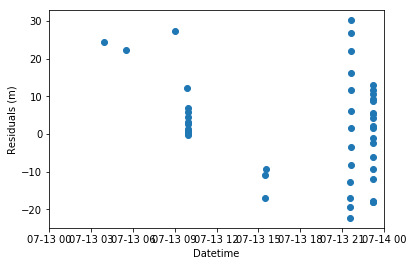

In [22]:
%matplotlib inline
residuals = observedRangeSeries - estimatedRangeSeries
import matplotlib.pyplot as plt
plt.scatter(residuals.index, residuals)
plt.xlim(startCollectionDate, odDate)
plt.xlabel('Datetime')
plt.ylabel('Residuals (m)')
plt.show()

## Propagating the solution 
Propagating the solution and saving the PV coordinates

In [23]:
dt = 30.0
date_start = datetime_to_absolutedate(startCollectionDate)
date_end = datetime_to_absolutedate(odDate)
date_current = date_start

while date_current.compareTo(date_end):
    PV = estimatedPropagator.getPVCoordinates(date_current, itrf)
    date_current = date_current.shiftedBy(dt)